# Udacity - Lane lines detection project
## Bo Fan
### The experimental results are in folder test_videos_output

In [1]:
#import several packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import math
%matplotlib inline

# import packages for video processing
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
# Helper functions provided by Udacity (no change)
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## My lane line detection pipeline and helper functions

In [3]:
#Removing outlier slopes from the averaging performed below in lane_lines
def remove_outliers(slopes, k = 2.5):
    # remove slopes which are outside the confidence region
    mean = np.mean(slopes)
    std = np.std(slopes)
    for slope in slopes:
        if (k * std) < abs(slope - mean):
            slopes.remove(slope)
    return slopes

def collect_lines(lines):
    # group the coordinates and slopes of the lines based on pos and negative slopes
    left_linepts = []
    left_lineslopes = []
    right_linepts = []
    right_lineslopes = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1) / (x2-x1)
            if slope < 0:
                left_linepts.append(line)
                left_lineslopes.append(slope)
            else:
                right_linepts.append(line)
                right_lineslopes.append(slope)
    return left_linepts, left_lineslopes, right_linepts, right_lineslopes

def average_pos(lines):
    # compute the average postions given a group of coordinates
    avg_pos = [sum(col)/len(col) for col in zip(*lines)]
    return avg_pos 
    
def extropolate_line(line_pos, slope, yt1, yt2):
    # extropolate a line segment using the two end points, given the slope
    # the range of the y axis is from yt1 to yt2.
    for x1,y1,x2,y2 in line_pos:
        x = int(np.mean([x1, x2])) #mean pos 
        y = int(np.mean([y1, y2])) #mean pos
        b = y - slope * x 
        avg_linepts = [int((yt1 - b)/slope), yt1, int((yt2 - b)/slope), yt2] # 4 coordinates of a extropolated line 
    return avg_linepts

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = detect_lanelines(image)
    return result

def detect_lanelines(img):
    # lane line detection pipeline
    """
    # img: input image
    # out: detected lines + original image
    """
    #Gray-scale it
    gray_img = grayscale(img)
    
    #Smooth it using gaussian gilter
    kernel_size = 7
    blur_img = gaussian_blur(gray_img, kernel_size)
    
    #Run Canny edge detection
    low_threshold = 85
    high_threshold = 185
    edges = canny(blur_img, low_threshold, high_threshold)
    
    # Find the ROI (Trapezoidal)
    img_shape = image.shape
    topleft_pt = (445, 323)  # (x, y)
    topright_pt = (555, 323) # (x, y)
    vertices = np.array([[(0,img_shape[0]),topleft_pt, topright_pt, (img_shape[1],img_shape[0])]], dtype=np.int32)  
    masked_edges = region_of_interest(edges, vertices)

    # Parameters for Hough transform
    rho = 6 # distance resolution in pixels of the Hough grid
    deg = 7
    theta =  deg * (np.pi/180) # angular resolution in radians of the Hough grid
    threshold = 55     # minimum number of votes 
    min_line_len = 23 #minimum number of pixels making up a line
    max_line_gap = 23    # maximum gap in pixels between connectable line segments
    line_img = 0 * np.copy(img) # creating a blank to draw lines on

    # Run Hough transform on detected edges
    # Output "lines" : an array list consits of endpoints of line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), min_line_len, max_line_gap)
    
    #Compute coordinates (endpoints) and slopes for the left and right lines' group
    left_linepts, left_slopes, right_linepts, right_slopes = collect_lines(lines)
    
    #Average the line positions
    avg_left_pts, avg_right_pts = average_pos(left_linepts), average_pos(right_linepts)

    #Remove outliers of slopes, and compute the mean
    avg_left_slope, avg_right_slope = np.mean(remove_outliers(left_slopes)), np.mean(remove_outliers(right_slopes)) 
    
    #Extrapolate the line segments 
    yt1, yt2 = topleft_pt[1], img_shape[0] - 1
    extavg_left_pts = []
    extavg_right_pts = []
    extavg_left_pts = extropolate_line(avg_left_pts, avg_left_slope, yt1, yt2)
    extavg_right_pts = extropolate_line(avg_right_pts, avg_right_slope, yt1, yt2)
    lines = [[extavg_left_pts], [extavg_right_pts]]
    
    # draw the line segments and combine it with the original input
    draw_lines(line_img, lines)
    combo_img = weighted_img(line_img, img)
    return combo_img


## Lane lines detection on images

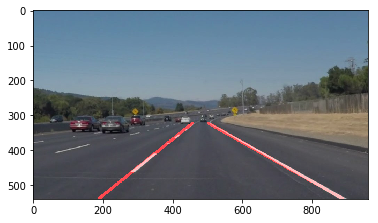

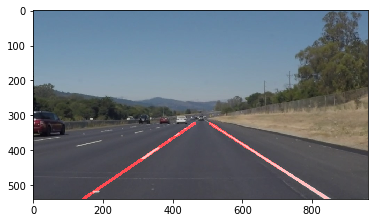

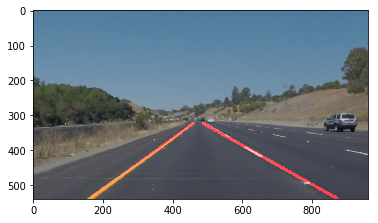

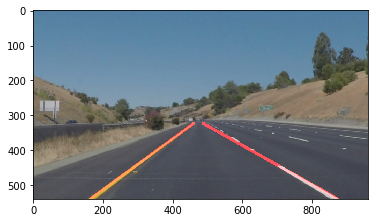

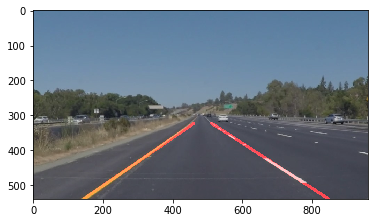

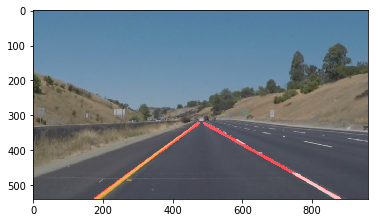

In [4]:
test_imgs = os.listdir("test_images/")
for i in test_imgs: 
    i = 'test_images/' + i
    image = mpimg.imread(i)
    #plt.imshow(image)
    #plt.show()
    
output_dir = "test_images_output" 
j = 0
for i in test_imgs: 
    i = 'test_images/' + i
    image = mpimg.imread(i)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    lane_image = detect_lanelines(image)
    plt.imshow(lane_image)
    out_filepath = output_dir + '/' + test_imgs[j]
    plt.imsave(out_filepath, lane_image)
    j += 1
    plt.show()

# Lane line detection on solid white lane video

In [5]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████▊| 221/222 [00:05<00:00, 42.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 6.21 s


## Lane line detection on solid yellow lane video

In [6]:
white_output = 'test_videos_output/solidYellowLeft.mp4'
clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
clip1.reader.close()
clip1.audio.reader.close_proc()

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████▉| 681/682 [00:22<00:00, 21.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 23.8 s
